# Geospatial Analysis & Mapping

This notebook contains explanations and examples for Geospatial Analysis & Mapping.

To handle geographic data, we will use geopandas, which combines the data manipulation tools of pandas and geospatial functionality of libraries like shapely and fiona. In particular, it is very useful to read geospatial like formats like Shapefiles, GeoJSON and GeoPackage.

We'll begin with an illustrative example that demonstrates the key concepts and tools we'll be using. This will provide a clear foundation before we dive into two case studies. 

## Introduction: Example

We'll make use of two powerful libraries that complement incredibly well with geopandas, cartopy and geoplot to plot import, handle and plot the earthquakes across the world with an attractive map.

Source: The Python Graph Gallery, barbierjoseph.com

In [14]:
#path
import os
os.chdir(r"\\cet.comp.cec.eu.int\compedmacompcet\CET\python_training\Python_CET_Crash_Course\input")

# data manipulation
import numpy as np
import pandas as pd
import geopandas as gpd

# visualization
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.font_manager import FontProperties # to handle fonts 
from highlight_text import fig_text, ax_text # to use bold text
from matplotlib.patches import FancyArrowPatch

# geospatial manipulation
import cartopy.crs as ccrs


First we retrieve from "The Python Graph Gallery" repository the world layer dataset and earthquakes using geopandas. By the way, this website is a great visual dictionary of many possible graphs, when I am trying to see ways of visualizing my data, I usually go there to get inspiration.

In [15]:
proj = ccrs.Mercator()

# connect to the github URL of the world map
world = gpd.read_file(r"all_world.geojson")
world = world[~world['name'].isin(["Antarctica", "Greenland"])]
world = world.to_crs(proj.proj4_init)
world.head()

#Load earthquake data
df = pd.read_csv(r"earthquakes.csv")
print("Shape of the dataframe: ",df.shape)
df.head()

Shape of the dataframe:  (14530, 10)


,Date,Time (utc),Region,Magnitude,Depth (km),Latitude,Longitude,Mode,Map,year
0,23/06/2024,04:51:49,"Mindanao, Philippine",4.8,342,8.01,125.20,A,-,2024.0
1,23/06/2024,03:58:03,Near Coast of Venezuela,5.9,105,10.80,-62.65,A,-,2024.0
2,23/06/2024,03:12:08,"Near East Coast of Honshu, japan",5.0,55,37.16,141.09,A,-,2024.0
3,22/06/2024,20:46:51,Near Coast of Peru,5.3,64,-15.79,-74.47,A,-,2024.0
4,22/06/2024,18:08:44,Afghanistan-Tajikistan Border Region,3.8,179,36.36,71.45,M,-,2024.0


We apply pandas methods to restrict the data.

In [69]:
# Filter dataset: big earth quakes only
df = df[df['Depth (km)']>=0.01] # depth of at least 10 meters

# Sort: big bubbles must be below small bubbles for visibility
df.sort_values(by='Depth (km)', ascending=False, inplace=True)

print("Shape of the dataframe: ",df.shape)
df.head()

Shape of the dataframe:  (14522, 10)


,Date,Time (utc),Region,Magnitude,Depth (km),Latitude,Longitude,Mode,Map,year
7961,20/02/2019,06:50:47,Banda Sea,5.0,2026,-6.89,129.15,A,-,2019.0
6813,07/07/2019,07:50:53,"Eastern New Guinea Reg, P.N.G.",5.4,1010,-5.96,147.90,A,-,2019.0
8293,17/01/2019,14:01:50,Fiji Islands,4.7,689,-18.65,179.44,A,-,2019.0
11258,03/01/2018,06:42:58,Fiji Islands Region,5.5,677,-19.93,-178.89,A,-,2018.0
9530,06/09/2018,18:22:24,Fiji Islands Region,5.8,672,-18.88,179.30,A,-,2018.0


Before adding our data points and layers into a map, We first need a background/blank/canvas map. There are many ways of doing it, but a good one is using cartopy projection tool and matplotlib for overall plotting.

Mercator projection: https://en.wikipedia.org/wiki/Mercator_projection


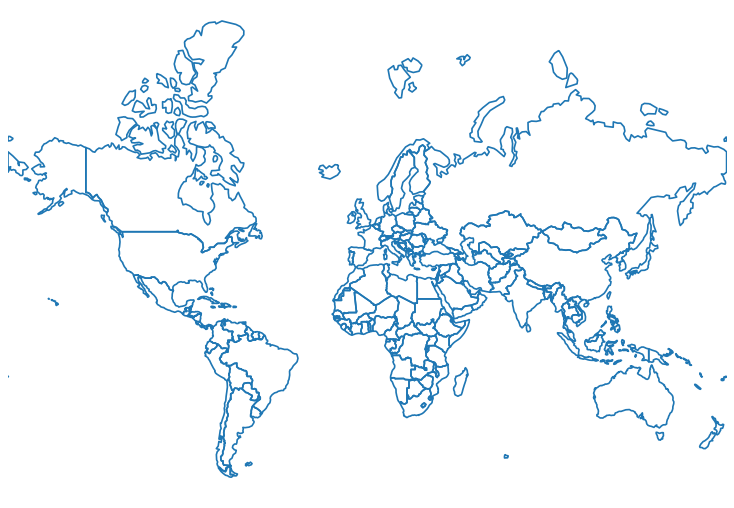

In [70]:
# we invoke the cartopy Mercator projection.
proj = ccrs.Mercator() 

# matplotlib overall plotting. This creates a figure that is 12 inches wide and 8 inches tall. dpi=80: Stands for "Dots Per Inch." 
# This sets the resolution of the figure. A higher DPI (e.g., 300) would result in a higher-resolution, crisper image but a larger file size.
# This is the most important part for mapping. It tells Matplotlib to create the axis (ax) using the specific projection we defined earlier (proj). 
# This is what makes it a geographic map instead of a standard graph.

fig, ax = plt.subplots(figsize=(12, 8), dpi=80, subplot_kw={'projection':proj})
ax.set_axis_off()

# background map
world.boundary.plot(ax=ax)

plt.show()

Now we can add our layers. We basically add the lat/lon data points. With the "size" argumento of ax.scatter, we adjust the size of the dots by the depth of the earthquake.

When creating this map, we are effectively working with two different spatial languages. The map canvas (ax) is set to speak 'Mercator', a language where locations are defined in meters. Our background map (world.boundary) is smart and automatically translates itself into this 'Mercator' language. However, our earthquake data, stored as Longitude and Latitude, is in a different language called 'WGS84' (or unprojected decimal degrees). We represent this source language in code as ccrs.PlateCarree(). The command proj.transform_points(pc, ...) acts as a translator, converting points from the 'WGS84' language (pc) into the 'Mercator' language (proj). Using Mercator() for both the target and the source would be like trying to translate from French to French; it doesn't work because the source data isn't actually in Mercator meters, it's in degrees. Specifying PlateCarree() for the source is what tells the translator the original language of our coordinates, allowing for a correct transformation onto the Mercator map.

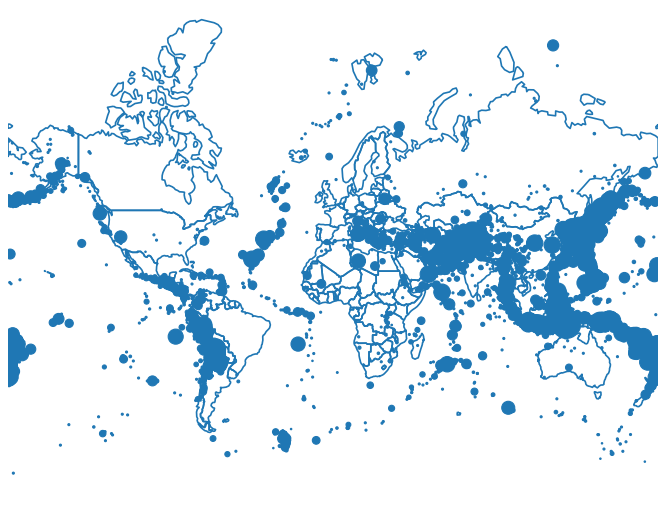

In [71]:
# bubble map
proj = ccrs.Mercator()
fig, ax = plt.subplots(figsize=(12, 8), dpi=80, subplot_kw={'projection':proj})
ax.set_axis_off()

# background map to put on top of our matplotlib canva
world.boundary.plot(ax=ax)

# transform the coordinates to the projection's CRS
pc = ccrs.PlateCarree()
new_coords = proj.transform_points(pc, df['Longitude'].values, df['Latitude'].values)

# bubble on top of the map
ax.scatter(
   new_coords[:, 0], new_coords[:, 1],
   s=df['Depth (km)']/3, # size of the bubbles
   zorder=10, # this specifies to put bubbles on top of the map
)

plt.show()

Now we can add some aesthetics, like colouring.

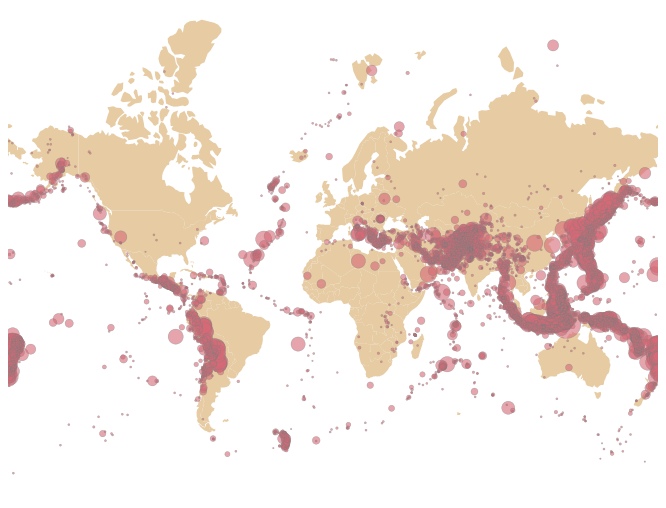

In [72]:
# change colors
# colors
background_color = 'white'
bubble_color = '#d66976' #this is the standard color language

# initialize the figure
proj = ccrs.Mercator()
fig, ax = plt.subplots(figsize=(12, 8), dpi=80, subplot_kw={'projection':proj})
fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
ax.set_axis_off()

# background map
world.boundary.plot(ax=ax, linewidth=0, facecolor= '#e6cba3') # we add a map colour

# transform the coordinates to the projection's CRS
pc = ccrs.PlateCarree()
new_coords = proj.transform_points(pc, df['Longitude'].values, df['Latitude'].values)

# bubble on top of the map
ax.scatter(
   new_coords[:, 0], new_coords[:, 1],
   s=df['Depth (km)']/3,
   color=bubble_color,
   linewidth=0.4,
   edgecolor='grey', # we add an edgecolor
   alpha=0.6,
   zorder=10,
)

plt.show()

### Bonus: More aesthetics

So what we're doing here is adding some text to make it a publication-ready map. First, we write a little helper function to draw those nice curved arrows we'll use for annotations. Then, we get into the nitty-gritty of design, we pick our colors as we do above, load in some custom fonts to make it look professional, and set up our figure with a our map projection.

Finally, we add all the context that turns this from a bunch of dots into a real narrative. We put in a strong title and subtitle, credit our sources, and then use those arrows and text boxes we prepared earlier to point out and explain the major tectonic plate boundaries that are causing all this activity. The goal is to not just show you the data, but to help you understand the powerful geological forces behind it.


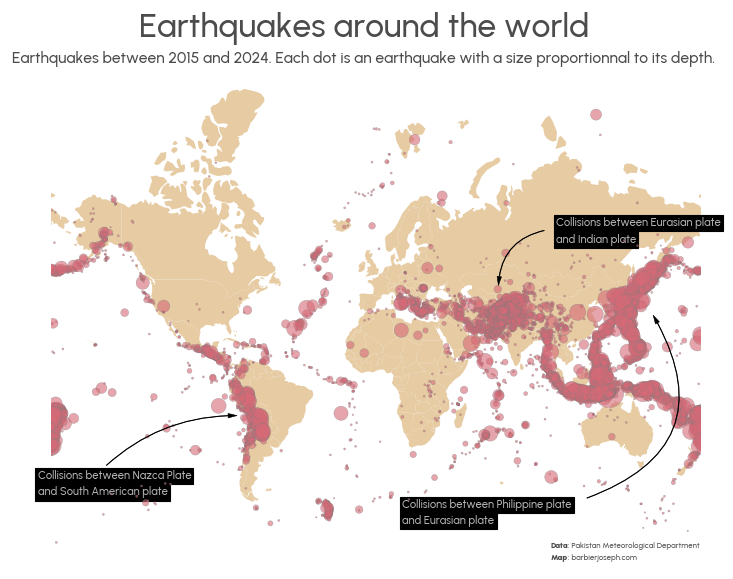

In [16]:
def draw_arrow(tail_position, head_position, invert=False, radius=0.5, color='black', fig=None):
   if fig is None:
      fig = plt.gcf()
   kw = dict(arrowstyle="Simple, tail_width=0.5, head_width=4, head_length=8", color=color, lw=0.5)
   if invert:
      connectionstyle = f"arc3,rad=-{radius}"
   else:
      connectionstyle = f"arc3,rad={radius}"
   a = FancyArrowPatch(
      tail_position, head_position,
      connectionstyle=connectionstyle,
      transform=fig.transFigure,
      **kw
   )
   fig.patches.append(a)

# title and aesthetics
# colors
background_color = 'white'
text_color = 'white'
bubble_color = '#d66976'
alpha_text = 0.7

# fonts
font_path = r'Urbanist_font/static/Urbanist-Medium.ttf'
font = FontProperties(fname=font_path)
font_path = r'Urbanist_font/static/Urbanist-Black.ttf'
bold_font = FontProperties(fname=font_path)

# initialize the figure
fig, ax = plt.subplots(figsize=(12, 8), dpi=80, subplot_kw={'projection':proj})
fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
ax.set_axis_off()

# background map
world.boundary.plot(ax=ax, linewidth=0, edgecolor = 'black', facecolor='#e6cba3') # we can also use facecolor = 'white' for example

# transform the coordinates to the projection's CRS
pc = ccrs.PlateCarree()
new_coords = proj.transform_points(pc, df['Longitude'].values, df['Latitude'].values)

# bubble on top of the map
ax.scatter(
   new_coords[:, 0], new_coords[:, 1],
   s=df['Depth (km)']/3,
   color=bubble_color,
   linewidth=0.4,
   edgecolor='grey',
   alpha=0.6,
   zorder=10,
)

# title
fig_text(
   x=0.5, y=0.98, s='Earthquakes around the world',
   color='black', fontsize=30, ha='center', va='top', font=font,
   alpha=alpha_text
)

# subtitle
fig_text(
   x=0.5, y=0.92, s='Earthquakes between 2015 and 2024. Each dot is an earthquake with a size proportionnal to its depth.',
   color='black', fontsize=14, ha='center', va='top', font=font, alpha=alpha_text
)

# credit
text = """
<Data>: Pakistan Meteorological Department
<Map>: barbierjoseph.com
"""
fig_text(
   x=0.85, y=0.16, s=text, color='black', fontsize=7, ha='right', va='top',
   font=font, highlight_textprops=[{'font': bold_font}, {'font': bold_font}],
   alpha=alpha_text
)

# although probably not useful for us, we can also draw arrows 
# nazaca plate
highlight_textprops = [
   {"bbox": {"facecolor": "black", "pad": 2, "alpha": 1}, "alpha": alpha_text},
   {"bbox": {"facecolor": "black", "pad": 2, "alpha": 1}, "alpha": alpha_text}
]
draw_arrow((0.23, 0.27), (0.37, 0.35), fig=fig, color='black', invert=True, radius=0.2)
fig_text(x=0.16, y=0.265, s='<Collisions between Nazca Plate>\n<and South American plate>', fontsize=10, color=text_color, font=font, highlight_textprops=highlight_textprops, zorder=100)

# india plate
draw_arrow((0.69, 0.64), (0.64, 0.55), fig=fig, color='black', radius=0.4)
fig_text(x=0.7, y=0.66, s='<Collisions between Eurasian plate>\n<and Indian plate>', fontsize=10, color=text_color, font=font, highlight_textprops=highlight_textprops, zorder=100)

# philippine plate
draw_arrow((0.73, 0.22), (0.8, 0.51), fig=fig, color='black', radius=0.6)
fig_text(x=0.54, y=0.22, s='<Collisions between Philippine plate>\n<and Eurasian plate>', fontsize=10, color=text_color, font=font, highlight_textprops=highlight_textprops, zorder=100)

plt.show()

## Case Study: catchment area analysis

Let's now use what we know to map a customer centric heatmap based on combined market shares of two manufacturing firms that attempt to merge in Poland. Before mapping anything, we need to make sure we have the following information when we do catchment area analysis. Every centroid will have a radii/drivetime, a centroid point (in coordinates), a buffer (polygon), the combined share per market/centroid. This aplies also when we do plant centric analysis. 

Because it's quicker and easier to show, we will draw catchment areas using a fixed radii (instead of drivetimes). Doing drivetimes would require us access to a driving API (i.e. openrouteservice, Google Platform).

In [17]:
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties

# Define your color bins and ranges for each dot, according to Parties combined market share. To do this we create a list of tuples.
# This is a very common and useful data structure in Python for defining things like color legends, category ranges, or lookup tables. 
# The code that uses this list can easily loop through these tuples to create a legend, assign colors to values, or classify data based on the defined ranges.
symbols = [
    ('<20%', 0.00, 0.20, "#ffffff"),
    ('20% - 30%', 0.20, 0.30, "#ffdada"),
    ('30% - 40%', 0.30, 0.40, "#ffafaf"),
    ('40% - 45%', 0.40, 0.45, "#ff2626"),
    ('45% - 50%', 0.45, 0.5, "brown"),
    ('>50%', 0.50, 1, "#774f4f")
]

# Extract bins and labels using list comprehensions (inline loop)
bins = [s[1] for s in symbols] + [symbols[-1][2]]  # [0.0, 0.2, 0.3, 0.4, 0.45, 0.5, 1.0]
labels = [s[0] for s in symbols]                   # ['<20%', '20% - 30%', ...]
colors = [s[3] for s in symbols]    

# Create a mapping dictionary from label to color
label_to_color = dict(zip(labels, colors))

# we import the customer location data together with the parties' combined market share information at each of the customer's catchment area
df = pd.read_csv(r"pcode_centric_capacity_cpb_catchment_80_onlyEEA_non_conf.csv")

# Map values to labels using pd.cut()
df['share_category'] = pd.cut(
    df['parties_combined'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Map labels to colors using the dictionary
df['color'] = df['share_category'].map(label_to_color)

# size of the bubbles
df['bubble_size'] = 10 # we could also use different size according to another variable

df.head()

,Unnamed: 0,cust_lat,cust_lon,product,catchment,parties_combined,radius,share_category,color,bubble_size
0,0,54.910106,23.850763,cpb,catchment_80,0.627066,466.536839,>50%,#774f4f,10
1,1,52.205485,21.044415,cpb,catchment_80,0.620575,466.536839,>50%,#774f4f,10
2,2,55.924790,21.080071,cpb,catchment_80,0.601902,466.536839,>50%,#774f4f,10
3,3,60.191617,24.913164,cpb,catchment_80,0.434872,466.536839,40% - 45%,#ff2626,10
4,4,52.240501,20.969200,cpb,catchment_80,0.619676,466.536839,>50%,#774f4f,10


<Axes: >

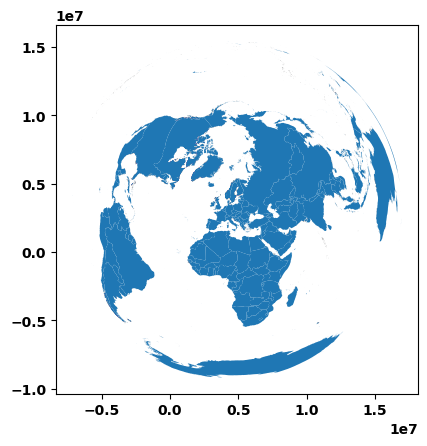

In [18]:
# this is the world, using the European centric projection 3035, preferred by GISCO. This is the projection we will use in most cases, as all our maps will require an EU map.
world = gpd.read_file(r"CNTR_RG_01M_2020_3035.shp\CNTR_RG_01M_2020_3035.shp")
world.plot()

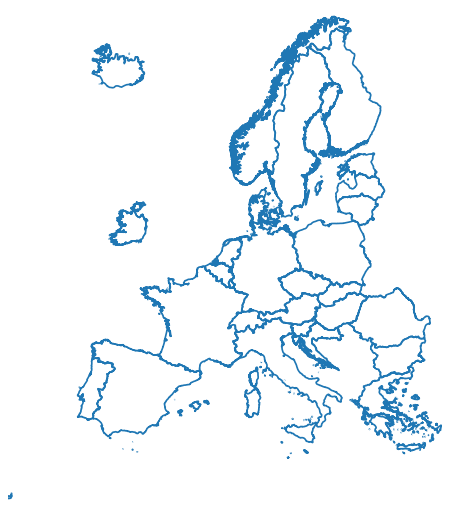

In [20]:
# we select EEA countries for visualization
eea_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
  'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
  'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
  'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden','Liechtenstein',
  'Iceland','Norway']
eea = world.loc[world.NAME_ENGL.isin(eea_countries)][['NAME_ENGL','geometry']]

# we again invoke the Mercator projection
proj = ccrs.Mercator()
fig, ax = plt.subplots(figsize=(12, 8), dpi=80, subplot_kw={'projection':proj})
ax.set_axis_off()

# background map
eea.boundary.plot(ax=ax)

# this helps us only visualize the EU part of the world.
plt.xlim(2000000, 6000000)
plt.ylim(1000000, 5500000)
plt.show()


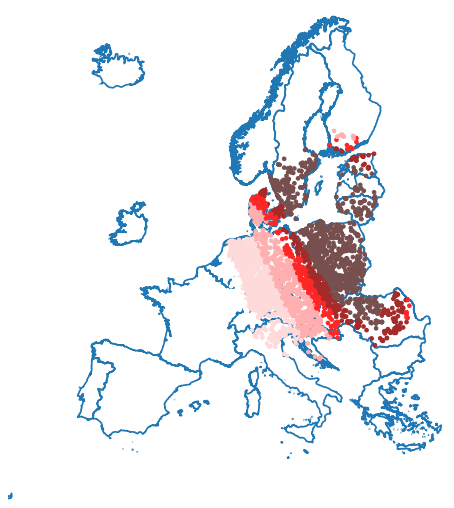

In [22]:
# transform the coordinates to the projection's CRS
pc = ccrs.PlateCarree()
new_coords = proj.transform_points(pc, df['cust_lon'].values, df['cust_lat'].values)

proj = ccrs.LambertAzimuthalEqualArea(
    central_longitude=10,
    central_latitude=52,
    false_easting=4321000,
    false_northing=3210000
)

# again, we start the matplotlib canvas
fig, ax = plt.subplots(figsize=(12, 8), dpi=80, subplot_kw={'projection':proj})
ax.set_axis_off()

# background map to put on top of our matplotlib canva
eea.boundary.plot(ax=ax)

plt.xlim(2000000, 6000000)
plt.ylim(1000000, 5500000)

# bubble on top of the map
ax.scatter(
    new_coords[:, 0], new_coords[:, 1],
    color = df['color'],
    s=df['bubble_size'], # size of the bubbles
    zorder=10, # this specifies to put bubbles on top of the map
)

plt.show()

As in our previous example, now we add the aesthetics, such as fonts, title, legend and colours altogether.

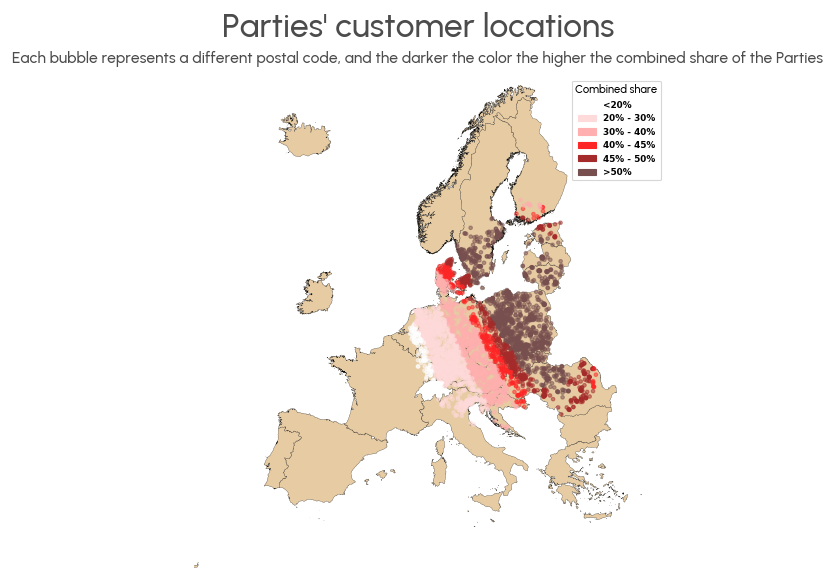

In [23]:
# title and aesthetics
# colors
background_color = 'white'
text_color = 'white'
bubble_color = '#d66976'
alpha_text = 0.7

# fonts
font_path = r'Urbanist_font/static/Urbanist-Medium.ttf'
font = FontProperties(fname=font_path)
font_path = r'Urbanist_font/static/Urbanist-Black.ttf'
bold_font = FontProperties(fname=font_path)

# initialize the figure
fig, ax = plt.subplots(figsize=(12, 8), dpi=80, subplot_kw={'projection':proj})
fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
ax.set_axis_off()

# background map
eea.boundary.plot(ax=ax,linewidth=0.2, edgecolor = 'black', facecolor='#e6cba3')

plt.xlim(2000000, 6300000)
plt.ylim(1000000, 5500000)

# bubble on top of the map
ax.scatter(
    new_coords[:, 0], new_coords[:, 1],
    color = df['color'],
    s=df['bubble_size'], # size of the bubbles
    alpha=0.5,
    zorder=10, # this specifies to put bubbles on top of the map
)

# title
fig_text(
   x=0.5, y=0.98, s="Parties' customer locations",
   color='black', fontsize=30, ha='center', va='top', font=font,
   alpha=alpha_text
)

# subtitle
fig_text(
   x=0.5, y=0.92, s='Each bubble represents a different postal code, and the darker the color the higher the combined share of the Parties',
   color='black', fontsize=14, ha='center', va='top', font=font, alpha=alpha_text
)

# Assume your color mapping looks like this:
color_map  ={'<20%': "#ffffff",
    '20% - 30%': "#ffdada",
    '30% - 40%': "#ffafaf",
    '40% - 45%': "#ff2626",
    '45% - 50%': "brown",
    '>50%': "#774f4f"}

# 1. Create legend patches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]

# 2. Add to your existing plot
title_font = FontProperties(weight='normal', size=9)
ax.legend(handles=legend_patches, title='Combined share', loc='upper right', frameon=True, fontsize = 8, title_fontproperties=font) # we recycle the font used in the example above

plt.show()